<a href="https://colab.research.google.com/github/grkidwell/time_based_waveforms/blob/master/inductor_waveforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inductor Waveforms

### Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
!rm -r time_based_waveforms
!git clone https://github.com/grkidwell/time_based_waveforms.git
sys.path.append('time_based_waveforms')

rm: cannot remove 'time_based_waveforms': No such file or directory
Cloning into 'time_based_waveforms'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [0]:
from unit_waveforms import Three_state

### Classes

In [0]:
class Inductor_current:
    
    def __init__(self,delta_t,vin,vout,idc,lout,t):
      
        self.delta_t=delta_t  #dictionary of time windows for each state
        self.t1 = self.delta_t['state1']
        self.t2 = self.delta_t['state2']
        self.Ts = sum(self.delta_t.values())
        self.vin=vin
        self.vout=vout
        self.idc=idc
        self.lout=lout
        
        self.k_object = Three_state(self.delta_t['state1'], self.delta_t['state2'])
        self.t=self.k_object.repeating(t)
        
        self.slope={"state1":(self.vin-self.vout)/self.lout, 
                    "state2":-self.vout/self.lout}
        self.delta_i=self.dxd(self.slope,self.delta_t)
        self.imin = self.idc-self.delta_i['state1']/2
        
        self.current=self.calculatecurrent()
        
    def confirm_voltsec_balance(self):
        return sum([self.slope[state]*self.delta_t[state] for state in  self.delta_t])
        
    def istart(self):
        return {'state1':self.imin,
                'state2':self.imin+self.delta_i['state1']}  
      
    def unit_pulse(self):       
        return {'state1': self.k_object.t1_unit_pulse(self.t),
                'state2': self.k_object.t2_unit_pulse(self.t)}
      
    def t_offset(self):
        return {'state1':0, 'state2':self.delta_t['state1']}
      
    def calculatecurrent(self):
        return sum([(self.istart()[state]+self.slope[state]*(self.t - self.t_offset()[state]))*self.unit_pulse()[state] for state in self.delta_t.keys()])
    
    def dxd(self,d1,d2):  #multiply the values of 2 dictionaries by key
        return {key: d1[key]*d2[key] for key in d1.keys()}
      



### Input parameters

In [0]:
Vin = 12
Vout = 8.8
iout = 10
fs = 0.777e6
Lout = 2.2e-6

duty = Vout/Vin
Ts = 1/fs
time_states={"state1":duty*Ts, "state2":(1-duty)*Ts}

In [0]:
def iLout(t):
    return Inductor_current(delta_t=time_states,vin=Vin,vout=Vout,idc=iout,lout=Lout,t=t).current

### Create single and multi pulse sequences

In [0]:
numdatapoints=1000  
numcycles = 4
tstep = np.round(numcycles*Ts/numdatapoints,10)

tarray=np.arange(0,Ts,tstep, dtype=float)
tarray_nperiod=np.arange(0,numcycles*Ts,tstep, dtype=float)

iLout_singlecycle=np.vectorize(iLout)(tarray)
iLout_multicycle=np.vectorize(iLout)(tarray_nperiod)


### Plots

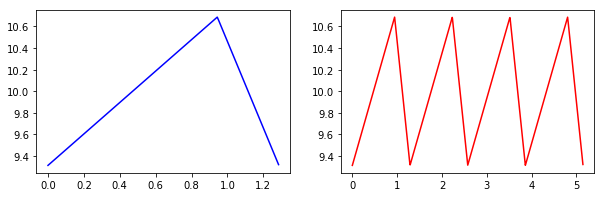

In [8]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(tarray*1e6,iLout_singlecycle, 'b')
ax2.plot(tarray_nperiod*1e6,iLout_multicycle, 'r')